In [1]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
nltk.download('stopwords')
nltk.download('popular')
import pprint
import itertools
import re
import pke
import string
from summarizer import Summarizer
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import tensorflow_hub as hub
from dataclasses import dataclass
from typing import List, Generic
import spacy
#https://spacy.io/universe/project/neuralcoref
import neuralcoref


[nltk_data] Downloading package stopwords to /Users/halim/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     /Users/halim/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     /Users/halim/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     /Users/halim/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     /Users/halim/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     /Users/halim/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading pac

### Summarize using bert-distill-summarizer
Tried to summarize with T5 and BART models too (check out Alt-summarizer.ipynb); however, they don't summarize as well, based on the Rouge-L score. This is still better.

UPDATE 1: Managed to Fine-tune Pegasus (current SoTa) with a small legal summarization (in plain englosh dataset). Although, the summaries are better than Bert, but the model is very very slow (more than 10 minutes on 2070 Ti). Moreover, Pegasus can only summarize on a maximum of 1024 tokens (it'll discard any tokens more than that). This I feel kind of defeats the purpose? So, I'll just stick with Bert here!

In [2]:
f = open("facebook_2015.txt","r")
full_text = f.read()

model = Summarizer()
result = model(full_text, min_length=60, max_length = 500 , ratio = 0.4)

summarized_text = ''.join(result)

In [3]:
def get_nouns_multipartite(text):
    out=[]

    extractor = pke.unsupervised.MultipartiteRank()
    extractor.load_document(input=text)
    #    not contain punctuation marks or stopwords as candidates.
    pos = {'PROPN'}
    #pos = {'VERB', 'ADJ', 'NOUN'}
    stoplist = list(string.punctuation)
    stoplist += ['-lrb-', '-rrb-', '-lcb-', '-rcb-', '-lsb-', '-rsb-']
    stoplist += stopwords.words('english')
    extractor.candidate_selection(pos=pos, stoplist=stoplist)
    # 4. build the Multipartite graph and rank candidates using random walk,
    #    alpha controls the weight adjustment mechanism, see TopicRank for
    #    threshold/method parameters.
    extractor.candidate_weighting(alpha=1.1,
                                  threshold=0.75,
                                  method='average')
    keyphrases = extractor.get_n_best(n=20)

    for key in keyphrases:
        out.append(key[0])

    return out

keywords = get_nouns_multipartite(full_text) 
print (keywords)
filtered_keys=[]
for keyword in keywords:
    if keyword.lower() in summarized_text.lower():
        filtered_keys.append(keyword)
        
print (filtered_keys)

['facebook principles', 'facebook', 'statement', 'responsibilities', 'srr', 'rights', 'special provisions', 'platform', 'facebook services', 'california', 'state', 'limited', 'applications', 'damages', 'data policy', 'commercial content served', 'united states', 'known', 'implied warranties including', 'account security']
['facebook principles', 'facebook', 'statement', 'responsibilities', 'srr', 'rights', 'special provisions', 'platform', 'facebook services', 'california', 'state', 'limited', 'data policy', 'commercial content served', 'united states']


### Above approximates how lossy our summaries are
The code above essentially ranks the importance of each words using TopicRank. It seems we capture most topics discussed without dropping too many important ones.

In [4]:

"""
Do some pre-processing
"""
paragraphs = summarized_text.split("\n\n")
cleaned_sentences=[]
for paragraph in paragraphs:
    for sent in sent_tokenize(paragraph):
        lower_token = [word.lower() for word in sent.split()]
        lower_cased = " ".join([word for word in lower_token])
        punct_removed = re.sub(r'[^\w\s]','',lower_cased)
        if len(punct_removed.split()) > 2:
            cleaned_sentences.append(punct_removed)

### Rank the importance of each sentence by using page-rank

In [5]:
print("Downloading embeddings")
url = "https://tfhub.dev/google/universal-sentence-encoder/4"
embeddings = hub.load(url)
print("Done downloading")

sent_len = len(cleaned_sentences)
sent_embed = embeddings(cleaned_sentences)

similarity_matrix = np.zeros([sent_len, sent_len])
for i in range(sent_len):
    for j in range(sent_len):
        if i != j:
            similarity_matrix[i][j] = cosine_similarity([sent_embed[i].numpy()], [sent_embed[j].numpy()])

graph = nx.from_numpy_array(similarity_matrix)
scores = nx.pagerank(graph)
ranked_sentences = sorted(((scores[i],s) for i,s in enumerate(cleaned_sentences)), reverse=True)
#Ranked top 10 important sentences using page rank
TOP_N_IMPT = 10
top_n_sent = [ranked_sentences[i][1] for i in range(TOP_N_IMPT)]

print("Sentence Importances :")
for i, sent in enumerate(top_n_sent):
    print("n°%d : %s" % (i, sent))

INFO:absl:Using /var/folders/3l/0t74styx5wz0y5tkfgsvhycwfc38wl/T/tfhub_modules to cache modules.


Done downloading
Sentence Importances :
n°0 : we do not give your content or information to advertisers without your consent
n°1 : by content we mean anything you or other users post provide or share using facebook services
n°2 : you will not post content or take any action on facebook that infringes or violates someone elses rights or otherwise violates the law
n°3 : although we provide rules for user conduct we do not control or direct users actions on facebook and are not responsible for the content or information users transmit or share on facebook
n°4 : you own all of the content and information you post on facebook and you can control how it is shared through your privacy and application settings
n°5 : we designed our data policy to make important disclosures about how you can use facebook to share with others and how we collect and can use your content and information
n°6 : when you publish content or information using the public setting it means that you are allowing everyone i

### Now let's start our analysis

In [6]:
@dataclass
class SummarizeClass:
    sent:str
    model: Summarizer
    embed: Generic
    summarized_text:str = None
    sentences: List[str] = None
    
    
    def summarize(self):
        self.summarized_text = model(self.sent, min_length=60, max_length = 500 , ratio = 0.4)
    
    def clean_sent(self):
        paragraphs = self.summarized_text.split("\n\n")
        cleaned_sentences=[]
        for paragraph in paragraphs:
            for sent in sent_tokenize(paragraph):
                lower_token = [word.lower() for word in sent.split()]
                lower_cased = " ".join([word for word in lower_token])
                punct_removed = re.sub(r'[^\w\s]','',lower_cased)
                if len(punct_removed.split()) > 2:
                    cleaned_sentences.append(punct_removed)
        self.sentences = cleaned_sentences
    def rank_sent(self, TOP_N_IMPT):
        sent_len = len(self.sentences)
        sent_embed = self.embed(self.sentences)
        similarity_matrix = np.zeros([sent_len, sent_len])
        for i in range(sent_len):
            for j in range(sent_len):
                if i != j:
                    similarity_matrix[i][j] = cosine_similarity([sent_embed[i].numpy()], [sent_embed[j].numpy()])

        graph = nx.from_numpy_array(similarity_matrix)
        scores = nx.pagerank(graph)
        ranked_sentences = sorted(((scores[i],s) for i,s in enumerate(cleaned_sentences)), reverse=True)
        #Ranked top 10 important sentences using page rank
        top_n_sent = [ranked_sentences[i][1] for i in range(TOP_N_IMPT)]
        return top_n_sent

In [7]:
model = Summarizer()
embeddings = hub.load(url)

In [8]:
file_paths = ['facebook_2015', 'facebook_dec_2019']
full_texts =[]
outputs =[]
for file_path in file_paths:
    f = open(f"{file_path}.txt","r")
    full_text = f.read()
    full_texts.append(full_text)
    Task = SummarizeClass(sent=full_text, model = model, embed = embeddings)
    Task.summarize()
    Task.clean_sent()
    TOP_N_IMPT = 10
    output = Task.rank_sent(TOP_N_IMPT=TOP_N_IMPT)
    outputs.append(output)
    print(f"The top {TOP_N_IMPT} sentences for {file_path}")
    print("SENTENCES :")
    for i, paraphrase in enumerate(top_para):
        print("n°%d : %s" % (i, paraphrase))
    print("---------")

Most important sentence for facebook_2015
['we do not give your content or information to advertisers without your consent', 'by content we mean anything you or other users post provide or share using facebook services', 'you will not post content or take any action on facebook that infringes or violates someone elses rights or otherwise violates the law', 'although we provide rules for user conduct we do not control or direct users actions on facebook and are not responsible for the content or information users transmit or share on facebook', 'you own all of the content and information you post on facebook and you can control how it is shared through your privacy and application settings', 'we designed our data policy to make important disclosures about how you can use facebook to share with others and how we collect and can use your content and information', 'when you publish content or information using the public setting it means that you are allowing everyone including people off 

In [9]:
import pandas as pd
nlp = spacy.load('en')
neuralcoref.add_to_pipe(nlp)


def entity_pairs(text, coref=True):
    text = re.sub(r'\n+', '.', text)  # replace multiple newlines with period
    text = re.sub(r'\[\d+\]', ' ', text)  # remove reference numbers
    text = nlp(text)
    ent_pairs = list()
    if coref:
        text = nlp(text._.coref_resolved)  # resolve coreference clusters
    sentences = [sent.string.strip() for sent in text.sents]  # split text into sentences
    for sent in sentences:
        sent = nlp(sent)
        spans = list(sent.ents) + list(sent.noun_chunks)  # collect nodes
        spans = spacy.util.filter_spans(spans)
        with sent.retokenize() as retokenizer:
            [retokenizer.merge(span) for span in spans]
        dep = [token.dep_ for token in sent]
        if (dep.count('obj')+dep.count('dobj'))>=1 or (dep.count('subj')+dep.count('nsubj'))>=1:
            for token in sent:
                if token.dep_ in ('obj', 'dobj'):  # identify object nodes
                    subject = [w for w in token.head.lefts if w.dep_
                               in ('subj', 'nsubj')]  # identify subject nodes
                    if subject:
                        subject = subject[0]
                        # identify relationship by root dependency
                        relation = [w for w in token.ancestors if w.dep_ == 'ROOT']  
                        if relation:
                            relation = relation[0]
                            # add adposition or particle to relationship
                            if relation.nbor(1).pos_ in ('ADP', 'PART'):  
                                relation = ' '.join((str(relation),
                                        str(relation.nbor(1))))
                        else:
                            relation = 'unknown'
                        subject, subject_type = refine_ent(subject, sent)
                        token, object_type = refine_ent(token, sent)
                        ent_pairs.append([str(subject), str(relation), str(token),
                                str(subject_type), str(object_type)])
    filtered_ent_pairs = [sublist for sublist in ent_pairs
                          if not any(str(x) == '' for x in sublist)]
    pairs = pd.DataFrame(filtered_ent_pairs, columns=['subject',
                         'relation', 'object', 'subject_type',
                         'object_type'])
    print('Entity pairs extracted:', str(len(filtered_ent_pairs)))
    return pairs


def refine_ent(ent, sent):
    unwanted_tokens = (
        'PRON',  # pronouns
        'PART',  # particle
        'DET',  # determiner
        'SCONJ',  # subordinating conjunction
        'PUNCT',  # punctuation
        'SYM',  # symbol
        'X',  # other
        )
    ent_type = ent.ent_type_  # get entity type
    if ent_type == '':
        ent_type = 'NOUN_CHUNK'
        ent = ' '.join(str(t.text) for t in
                nlp(str(ent)) if t.pos_
                not in unwanted_tokens and t.is_stop == False)
    elif ent_type in ('NOMINAL', 'CARDINAL', 'ORDINAL') and str(ent).find(' ') == -1:
        t = ''
        for i in range(len(sent) - ent.i):
            if ent.nbor(i).pos_ not in ('VERB', 'PUNCT'):
                t += ' ' + str(ent.nbor(i))
            else:
                ent = t.strip()
                break
    return ent, ent_type


#### Build Knowledge Graph

Entity pairs extracted: 16


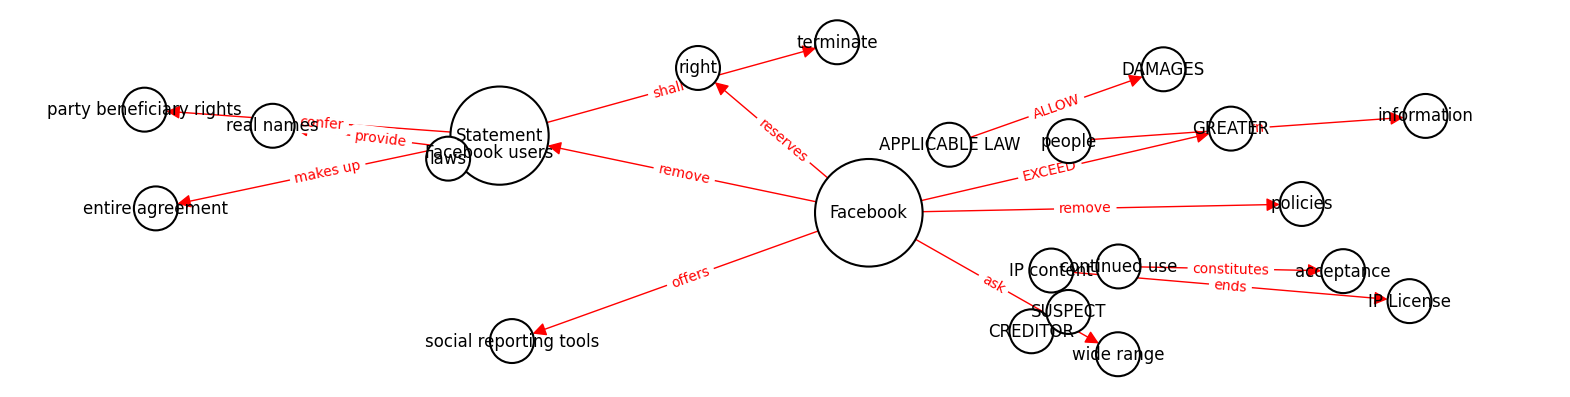

Entity pairs extracted: 19


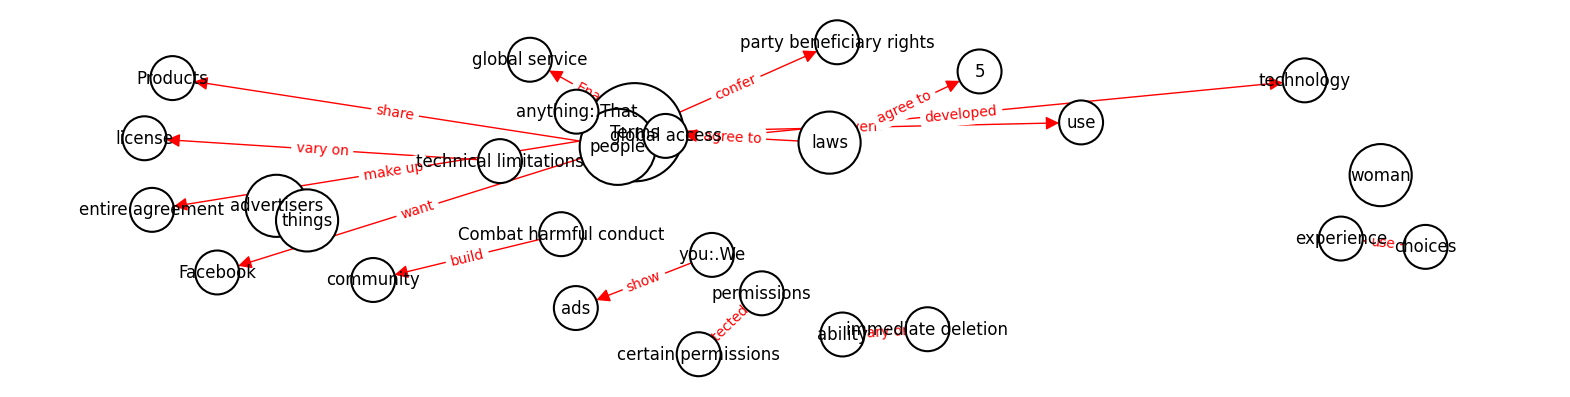

In [11]:
import networkx as nx
import matplotlib.pyplot as plt


def draw_kg(pairs):
    k_graph = nx.from_pandas_edgelist(pairs, 'subject', 'object',
            create_using=nx.MultiDiGraph())
    node_deg = nx.degree(k_graph)
    layout = nx.spring_layout(k_graph, k=0.15, iterations=20)
    plt.figure(num=None, figsize=(20, 5), dpi=100)
    nx.draw_networkx(
        k_graph,
        node_size=[int(deg[1]) * 1000 for deg in node_deg],
        arrowsize=20,
        linewidths=1.5,
        pos=layout,
        edge_color='red',
        edgecolors='black',
        node_color='white',
        )
    labels = dict(zip(list(zip(pairs.subject, pairs.object)),
                  pairs['relation'].tolist()))
    nx.draw_networkx_edge_labels(k_graph, pos=layout, edge_labels=labels,
                                 font_color='red')
    plt.axis('off')
    plt.show()

for text in full_texts:
    pairs = entity_pairs(text)
    draw_kg(pairs)